In [ ]:
import numpy as np

x_train = np.load('F:/PhD Lund/PythonCodes_Github/VVR080F_ANN-DL/Data_Regression/X_train.npy')
x_test = np.load('F:/PhD Lund/PythonCodes_Github/VVR080F_ANN-DL/Data_Regression/X_test.npy')
y_train = np.load('F:/PhD Lund/PythonCodes_Github/VVR080F_ANN-DL/Data_Regression/y_train.npy')
y_test = np.load('F:/PhD Lund/PythonCodes_Github/VVR080F_ANN-DL/Data_Regression/y_test.npy')

print('x train shape', x_train.shape)
print('y train shape', y_train.shape)
print('x test shape', x_test.shape)
print('y test shape', y_test.shape)

print('x train type', x_train.dtype)
print('y train type', y_train.dtype)
print('x test type', x_test.dtype)
print('y test type', y_test.dtype)

In [ ]:
import matplotlib.pyplot as plt

print('data total', np.concatenate((y_train, y_test), axis = 0).shape)
plt.hist(np.concatenate((y_train, y_test), axis = 0));

In [ ]:
def mape(real, predict):
    
    """
    Will give MAPE(%) between real and predict values 
    
    """
    
    error = np.abs(real.ravel() - predict.ravel())
    
    real_masked = real.ravel()[real.ravel() != 0]
    error_masked = error.ravel()[real.ravel() != 0]
    
    return np.mean( (error_masked/real_masked) * 100 )


from scipy import stats

def r_squared(real, predict):
    
    """
    Will give R2 (0-1) between real and predict values 
    
    """
    _, _, r_value, _, _ = stats.linregress(real, predict)
    return r_value**2

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

In [32]:
num_of_outputs = 1

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1).astype(np.float32)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1).astype(np.float32)

y_train = y_train.astype(np.float32).reshape(-1, num_of_outputs)
y_test = y_test.astype(np.float32).reshape(-1, num_of_outputs)

x_train_torch = torch.from_numpy(x_train)
x_test_torch = torch.from_numpy(x_test)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train_torch, y_train_torch)
test_ds  = TensorDataset(x_test_torch,  y_test_torch)

batch_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [33]:
x_train_torch.shape

torch.Size([887, 12, 1])

In [36]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_features_each_time_step, hidden_size, num_layers, bias, num_of_outputs):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_features_each_time_step,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bias=bias,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_of_outputs)

    def forward(self, x):
        out, _ = self.lstm(x)           
        last = out[:, -1, :]           
        y = self.fc(last)             
        return y

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTMRegressor(
    input_features_each_time_step=1,
    hidden_size=24,
    num_layers=1,
    bias=True,
    num_of_outputs=1
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 200

for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        if y_batch.ndim == 1:
            y_batch = y_batch.unsqueeze(1) 

        preds = model(x_batch)              
        loss = loss_fn(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        if y_batch.ndim == 1:
            y_batch = y_batch.unsqueeze(1)

        preds = model(x_batch)           
        y_true.append(y_batch.squeeze(1).cpu())
        y_pred.append(preds.squeeze(1).cpu())

y_true = torch.cat(y_true, dim=0).numpy()  
y_pred = torch.cat(y_pred, dim=0).numpy()  

print('MAPE', mape(y_true, y_pred))
print('R2', r_squared(y_true, y_pred))

MAPE 21.170538
R2 0.6845852204516238


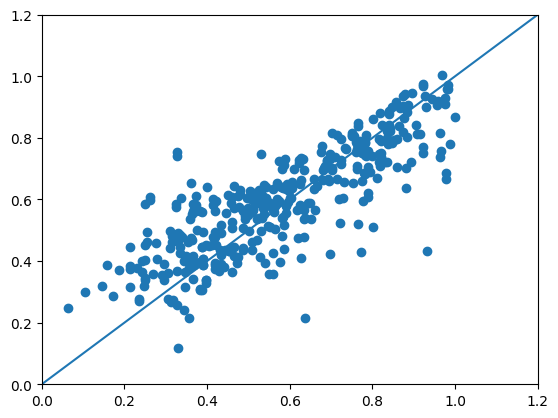

In [38]:
plt.scatter(y_true, y_pred)
plt.xlim([0, 1.2])
plt.ylim([0, 1.2])
plt.plot([0, 1.2], [0,1.2])